# MomentsLD makes me sad :(

In [2]:
import os
import moments
from tqdm import tqdm
import numpy as np
import msprime
import dadi
import glob
import demes
import ray
import json
os.chdir('/sietch_colab/akapoor/Demographic_Inference')
import src.demographic_models as demographic_models

## Functions

I want to see what's going wrong with my MomentsLD specific scripts. I will copy and paste them here and will debug.

Functions in the preprocessing module

In [3]:
def sample_params(lower_bound_params, upper_bound_params):
    sampled_params = {}
    for key in lower_bound_params:
        lower_bound = lower_bound_params[key]
        upper_bound = upper_bound_params[key]
        sampled_value = np.random.uniform(lower_bound, upper_bound)
        sampled_params[key] = int(sampled_value)


        # Check if the sampled parameter is equal to the mean of the uniform distribution
        mean_value = (lower_bound + upper_bound) / 2
        if sampled_value == mean_value:
            # Add a small random value to avoid exact mean, while keeping within bounds
            adjustment = np.random.uniform(-0.1 * (upper_bound - lower_bound), 0.1 * (upper_bound - lower_bound))
            adjusted_value = sampled_value + adjustment
            
            # Ensure the adjusted value is still within the bounds
            adjusted_value = max(min(adjusted_value, upper_bound), lower_bound)
            sampled_params[key] = int(adjusted_value)

    return sampled_params

In [4]:
def run_msprime_replicates(sampled_params, experiment_config, folderpath):

    if experiment_config["demographic_model"] == "bottleneck_model":
        demographic_model = demographic_models.bottleneck_model

    elif experiment_config["demographic_model"] == "split_isolation_model":
        demographic_model = demographic_models.split_isolation_model_simulation

    else:
        raise ValueError(f"Unsupported demographic model: {experiment_config['demographic_model']}")

    g = demographic_model(sampled_params)
    demog = msprime.Demography.from_demes(g)

    # Create directory for storing VCFs
    output_folder = folderpath
    os.makedirs(output_folder, exist_ok=True)

    print(f"Samples: {experiment_config['num_samples']}")
    
    tree_sequences = msprime.sim_ancestry(
        samples = experiment_config['num_samples'],
        # {"N1": experiment_config['num_samples']['N1'], "N2": experiment_config['num_samples']['N2']},
        demography=demog,
        sequence_length=experiment_config['genome_length'],
        recombination_rate=experiment_config['recombination_rate'],
        num_replicates=experiment_config['num_reps'],
        random_seed=experiment_config['seed'],
    )

    # List to store file paths of the generated VCFs
    vcf_filepaths = []

    for ii, ts in enumerate(tree_sequences):
        ts = msprime.sim_mutations(ts, rate=experiment_config['mutation_rate'], random_seed=ii + 1)
        vcf_name = os.path.join(output_folder, f'rep.{ii}.vcf')
        with open(vcf_name, "w+") as fout:
            ts.write_vcf(fout, allow_position_zero=True)
        os.system(f"gzip {vcf_name}")

        # Store the compressed VCF file path
        vcf_filepaths.append(f"{vcf_name}.gz")

    # Write the metadata file with all VCF file paths
    metadata_file = os.path.join(output_folder, "metadata.txt")
    with open(metadata_file, "w+") as metafile:
        metafile.write("\n".join(vcf_filepaths))

    print(f"Metadata file written to {metadata_file}")

In [5]:
def write_samples_and_rec_map(experiment_config, folderpath):

    # Define the file paths
    samples_file = os.path.join(folderpath, f"samples.txt")
    flat_map_file = os.path.join(folderpath, f"flat_map.txt")

    print(f'Samples filepath: {samples_file}')
    print(f'Flat map filepath: {flat_map_file}')

    # Open and write the sample file
    with open(samples_file, "w+") as fout:
        fout.write("sample\tpop\n")

        # Dynamically define samples based on the num_samples dictionary
        sample_idx = 0  # Initialize sample index
        for pop_name, sample_size in experiment_config['num_samples'].items():
            for _ in range(sample_size):
                fout.write(f"tsk_{sample_idx}\t{pop_name}\n")
                sample_idx += 1

    # Write the recombination map file
    with open(flat_map_file, "w+") as fout:
        fout.write("pos\tMap(cM)\n")
        fout.write("0\t0\n")
        fout.write(f"{experiment_config['genome_length']}\t{experiment_config['recombination_rate'] * experiment_config['genome_length'] * 100}\n")

Functions in the demographic_models module

In [6]:
def split_isolation_model_simulation(sampled_params):

    # Unpack the sampled parameters
    Na, N1, N2, m, t_split = (
        sampled_params["Na"],  # Effective population size of the ancestral population
        sampled_params["N1"],  # Size of population 1 after split
        sampled_params["N2"],  # Size of population 2 after split
        sampled_params["m"],   # Migration rate between populations
        sampled_params["t_split"],  # Time of the population split (in generations)
    )

    b = demes.Builder()
    b.add_deme("Na", epochs=[dict(start_size=Na, end_time=t_split)])
    b.add_deme("N1", ancestors=["Na"], epochs=[dict(start_size=N1)])
    b.add_deme("N2", ancestors=["Na"], epochs=[dict(start_size=N2)])
    b.add_migration(demes=["N1", "N2"], rate=m)
    g = b.resolve()
    return g

Functions for the MomentsLD inference part

In [7]:
# Define your function with Ray's remote decorator
@ray.remote
def get_LD_stats(vcf_file, r_bins, flat_map_path, pop_file_path):
    ray.init(ignore_reinit_error=True)
    ld_stats = moments.LD.Parsing.compute_ld_statistics( #type:ignore
        vcf_file,
        rec_map_file=flat_map_path,
        pop_file=pop_file_path,
        pops=["N1", "N2"], # TODO: Change later
        r_bins=r_bins,
        report=False,
    )

    return ld_stats


In [8]:
def compute_ld_stats_parallel(folderpath, num_reps, r_bins):
    
    flat_map_path = os.path.join(folderpath, "flat_map.txt")
    pop_file_path = os.path.join(folderpath, "samples.txt")
    vcf_files = [
        os.path.join(folderpath, f"rep.{rep_ii}.vcf.gz")
        for rep_ii in range(num_reps)
    ]

    # Launch the tasks in parallel using Ray
    futures = [
        get_LD_stats.remote(vcf_file, r_bins, flat_map_path, pop_file_path)
        for vcf_file in vcf_files
    ]

    # Wait for all the tasks to complete and retrieve results
    results = ray.get(futures)
    return results

In [9]:
def run_inference_momentsLD(folderpath, demographic_model, p_guess, num_reps):
    """
    This should do the parameter inference for momentsLD
    index: unique simulation number
    """

    r_bins = np.array([0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3])

    print("parsing LD statistics")


    ld_stats = {}
    results = compute_ld_stats_parallel(folderpath, num_reps, r_bins)

    for i, result in enumerate(results):
        ld_stats[i] = result

    # print("computing mean and varcov matrix from LD statistics sums")
    mv = moments.LD.Parsing.bootstrap_data(ld_stats)  # type: ignore
    # print("SHAPE OF THE COVARIANCE MATRIX")
    # print(mv["varcovs"][-1].shape)
    # mv["varcovs"][-1].shape = (1, 1)

    if demographic_model == "bottleneck_model":
        demo_func = moments.LD.Demographics1D.three_epoch # type: ignore

    elif demographic_model == "split_isolation_model":
        demo_func = demographic_models.split_isolation_model_momentsLD

    else:
        raise ValueError(f"Unsupported demographic model: {demographic_model}")

    # Set up the initial guess
    p_guess = moments.LD.Util.perturb_params(p_guess, fold=0.1) # type: ignore
    opt_params, LL = moments.LD.Inference.optimize_log_lbfgsb( #type:ignore
        p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins, maxiter = 100, verbose = 3
    )

    physical_units = moments.LD.Util.rescale_params( # type: ignore
        opt_params, ["nu", "nu", "T", "m", "Ne"]
)

    opt_params, LL = moments.LD.Inference.optimize_log_lbfgsb( #type:ignore
    p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins, verbose = 3
    )

    opt_params_dict = {}
    if demographic_model == "bottleneck_model":

        opt_params_dict = {
            # "N0": opt_params[4],
            "Nb": opt_params[0] * opt_params[4],
            "N_recover": opt_params[1] * opt_params[4],
            "t_bottleneck_start": (opt_params[2]+opt_params[3]) * 2 * opt_params[4],
            "t_bottleneck_end": opt_params[3] * 2 * opt_params[4]
        }

    elif demographic_model == "split_isolation_model":
        physical_units = moments.LD.Util.rescale_params( #type:ignore
            opt_params, ["nu", "nu", "T", "m", "Ne"]
        )

        print(physical_units)

        opt_params_dict = {
            "N1": physical_units[0],
            "N2": physical_units[1],
            "t_split": physical_units[2],
            "m": physical_units[3], 
            'Na': physical_units[4]
        }

        print("best fit parameters:")
        print(f"  N(deme0)         :  {physical_units[0]:.1f}")
        print(f"  N(deme1)         :  {physical_units[1]:.1f}")
        print(f"  Div. time (gen)  :  {physical_units[2]:.1f}")
        print(f"  Migration rate   :  {physical_units[3]:.6f}")
        print(f"  N(ancestral)     :  {physical_units[4]:.1f}")
    
    # print(f'Moments LD results: {opt_params_dict}')

    return opt_params_dict


## Driver

In [10]:
# Load in the experiment_config.json
with open("/sietch_colab/akapoor/Demographic_Inference/experiment_config.json", "r") as f:
    experiment_config = json.load(f)

In [11]:
sampled_params = sample_params(experiment_config["lower_bound_params"], experiment_config["upper_bound_params"])
print(sampled_params)

{'t_split': 3371, 'N1': 2274, 'N2': 8321, 'Na': 18377, 'm': 0}


In [12]:
folderpath = f"/sietch_colab/akapoor/Demographic_Inference/testing_things/simulations/{experiment_config['demographic_model']}/"

In [13]:
run_msprime_replicates(sampled_params, experiment_config, folderpath)

Samples: {'N1': 20, 'N2': 20}
Metadata file written to /sietch_colab/akapoor/Demographic_Inference/testing_things/simulations/split_isolation_model/metadata.txt


In [14]:
write_samples_and_rec_map(experiment_config, folderpath)

Samples filepath: /sietch_colab/akapoor/Demographic_Inference/testing_things/simulations/split_isolation_model/samples.txt
Flat map filepath: /sietch_colab/akapoor/Demographic_Inference/testing_things/simulations/split_isolation_model/flat_map.txt


In [15]:
demographic_model = "split_isolation_model"

In [16]:
p_guess = p_guess = [0.1, 2, 0.075, 2, 10000]
num_reps = 100

In [17]:
opt_params_dict = run_inference_momentsLD(folderpath, demographic_model, p_guess, num_reps)

parsing LD statistics


2024-10-16 18:40:51,747	INFO worker.py:1781 -- Started a local Ray instance.
(get_LD_stats pid=2667074) Calling ray.init() again after it has already been called.


3       , -52439.7    , array([ 0.0951222  ,  1.95896    ,  0.0709626  ,  2.04211    ,  10410.8    ])
6       , -52376.9    , array([ 0.0951222  ,  1.957      ,  0.0709626  ,  2.04211    ,  10421.2    ])
9       , -35029.5    , array([ 0.191531   ,  1.73513    ,  0.0464343  ,  1.67564    ,  17612.7    ])
12      , -35022.1    , array([ 0.191531   ,  1.7334     ,  0.0464343  ,  1.67564    ,  17630.3    ])
15      , -31371.6    , array([ 0.172543   ,  1.6606     ,  0.0522723  ,  1.61509    ,  17885.7    ])
18      , -31363.8    , array([ 0.172543   ,  1.65894    ,  0.0522723  ,  1.61509    ,  17903.6    ])
21      , -26909.1    , array([ 0.113637   ,  1.39315    ,  0.0839459  ,  1.394      ,  19020.8    ])
24      , -26891.4    , array([ 0.113637   ,  1.39176    ,  0.0839459  ,  1.394      ,  19039.9    ])
27      , -26052.2    , array([ 0.143398   ,  1.53631    ,  0.0644781  ,  1.51312    ,  18380      ])
30      , -26042.3    , array([ 0.143398   ,  1.53477    ,  0.0644781  ,  1.51312 

In [18]:
opt_params_dict

{'N1': 2165.6082176928317,
 'N2': 7965.717126880145,
 't_split': 3132.407258348543,
 'm': 5.090429903285065e-08,
 'Na': 18942.83519058916}

In [19]:
sampled_params

{'t_split': 3371, 'N1': 2274, 'N2': 8321, 'Na': 18377, 'm': 0}

In [2]:
import pickle
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/preprocessing_results_obj.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.keys()

dict_keys(['training', 'validation', 'parameter_names'])

In [4]:
data['parameter_names']

['t_split', 'N1', 'N2', 'Na', 'm']

In [5]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/postprocessing_results.pkl', 'rb') as f:
    postprocessing = pickle.load(f)

In [6]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/models/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/num_hidden_neurons_1000_num_hidden_layers_3_num_epochs_500_dropout_value_0_weight_decay_0_batch_size_35_EarlyStopping_False/snn_results.pkl', 'rb') as f:
    snn_results = pickle.load(f)

In [7]:
snn_results['training']['predictions'].shape

(16, 5)

In [8]:
postprocessing['training']['normalized_predictions'].shape

(16, 10)

In [9]:
data['training']['momentsLD_predictions'].shape

(16, 5)

In [10]:
import numpy as np
normalized_momentsld_pred = (data['training']['momentsLD_predictions'] - np.mean(data['training']['momentsLD_predictions'], axis=0)) / np.std(data['training']['momentsLD_predictions'], axis=0)

In [11]:
normalized_momentsld_pred.shape

(16, 5)

In [12]:
snn_results['training']['predictions'].shape

(16, 5)

In [13]:
snn_results['training']['targets']

array([[-5.04823528, -0.66692704,  1.10501342,  6.65390294, -1.73239725],
       [-5.15146551,  0.52311433,  1.19948892, 11.01089442, -1.73239725],
       [-5.02745067,  0.34256116,  1.20928638, 11.97235936, -1.73239725],
       [-3.55347544,  0.24388675, -1.40173647, 11.42517269, -1.73239725],
       [-4.29617882, -1.55464682, -1.21873393,  7.77231289, -1.73239725],
       [-3.56005723, -1.07842032,  1.64772268,  8.31879259, -1.73239725],
       [-4.07309068, -1.56759346,  0.29917241, 12.05578058, -1.73239725],
       [-4.93530557, -1.63372631,  0.40729437,  9.11341509, -1.73239725],
       [-4.53693389,  0.87162395,  1.25617422,  8.26011495, -1.73239725],
       [-4.52134543, -1.45002395,  0.36810454,  8.17598677, -1.73239725],
       [-4.4316252 , -0.92690961,  1.16484791,  5.36158095, -1.73239725],
       [-3.63488182,  1.41958184,  0.2116951 , 11.29438518, -1.73239725],
       [-4.8920043 ,  0.37615245, -0.4499833 ,  9.80340757, -1.73239725],
       [-3.58014902,  0.20679637, -0.3

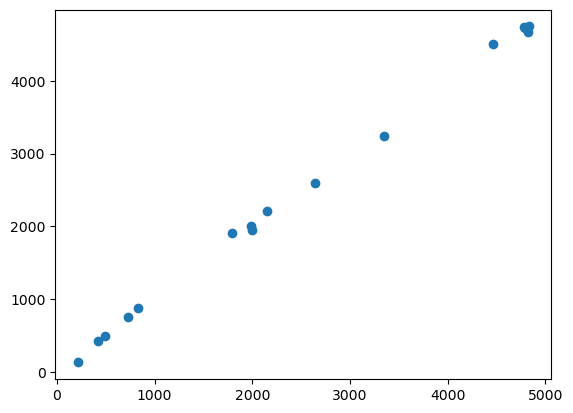

In [34]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(data['training']['momentsLD_predictions'][:,2], np.squeeze(data['training']['targets'])[:,0])

In [33]:
data['training']['momentsLD_predictions'][:,2]

array([ 422.61847192,  213.75324073,  491.54300019, 4777.38712398,
       2645.25408355, 4796.1981556 , 3345.45944814,  729.83279798,
       1791.84928908, 1996.26167518, 2148.65894402, 4465.16736154,
        827.53720463, 4824.88629234, 4829.7296348 , 1986.8727847 ])

In [19]:
np.squeeze(data['training']['targets'])

array([[  427,  3144,  8208, 11962,     0],
       [  129,  6545,  8478, 18125,     0],
       [  487,  6029,  8506, 19485,     0],
       [ 4742,  5747,  1044, 18711,     0],
       [ 2598,   607,  1567, 13544,     0],
       [ 4723,  1968,  9759, 14317,     0],
       [ 3242,   570,  5905, 19603,     0],
       [  753,   381,  6214, 15441,     0],
       [ 1903,  7541,  8640, 14234,     0],
       [ 1948,   906,  6102, 14115,     0],
       [ 2207,  2401,  8379, 10134,     0],
       [ 4507,  9107,  5655, 18526,     0],
       [  878,  6125,  3764, 16417,     0],
       [ 4665,  5641,  4165, 14808,     0],
       [ 4747,  3910,  1862, 13336,     0],
       [ 2002,  8939,   388, 15440,     0]])

In [35]:
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_2_top_values_1/simulation_results/software_inferences_sim_0.pkl', 'rb') as f:
    software_inferences = pickle.load(f)

In [36]:
software_inferences['simulated_params']

{'t_split': 753, 'N1': 381, 'N2': 6214, 'Na': 15441, 'm': 0}

In [24]:
data['parameter_names']

['t_split', 'N1', 'N2', 'Na', 'm']